In [2]:
import os
import sys
import time
import numpy as np
import imgaug 

In [3]:
from mrcnn.config import Config
from mrcnn import model as modellib, utils

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
from coco.coco import CocoDataset

Using TensorFlow backend.


In [4]:
#COCO_PRETRAINED_WEIGHTS_PATH = os.path.abspath("mask_rcnn_coco.h5")
DATASET_PATH = os.path.abspath("DATASETS/")
TRAIN_ANNOTATIONS_PATH = os.path.abspath("DATASETS/annotations/instances_train2017.json")
LOGS_PATH = os.path.abspath("LOGS")

In [5]:
class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"
    
    IMAGES_PER_GPU = 2 
    #the model fits only once on my 6GB GTX1060. 
    #fits twice on 12GB Tesla P100
    
    NUM_CLASSES = 1 + 80  #80 COCO classes + BG class

In [6]:
coco_train_annotatons = COCO(TRAIN_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=14.50s)
creating index...
index created!


In [7]:
#Train dataset
dataset_train = CocoDataset()
dataset_train.load_coco(dataset_dir=DATASET_PATH, subset="train", year=2017, class_ids=None,
                        class_map=None, return_coco=False, auto_download=False)
dataset_train.prepare()



# Validation dataset
dataset_val = CocoDataset()
dataset_val.load_coco(dataset_dir=DATASET_PATH, subset="val", year=2017, auto_download=False)
dataset_val.prepare()

loading annotations into memory...
Done (t=14.22s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [8]:
import numpy as np

augmentation = imgaug.augmenters.Fliplr(0.5)


LEARNING_RATES = np.linspace(0.005, 0.0001, 5)
np.append(LEARNING_RATES, 0.02) #add the original learning rate from the paper

histories = []

for lr in LEARNING_RATES:
    
    config = CocoConfig()

    config.LEARNING_RATE = lr
    #config.LEARNING_RATE = 0.0025
    config.LEARNING_MOMENTUM = 0.9

    # Weight decay regularization
    config.WEIGHT_DECAY = 0.0001
    
    print("TRAINING with, LR: {}, DECAY: {}".format(config.LEARNING_RATE, config.WEIGHT_DECAY))
    
    # Create model
    model = modellib.MaskRCNN(mode="training", config=config,
                              model_dir=LOGS_PATH)
        
    # Training - Stage 1
    print("Training network heads")
    hist1 = model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=1,
                layers='heads',
                augmentation=augmentation)

    # Training - Stage 2
    # Finetune layers from ResNet stage 4 and up
    print("Fine tune Resnet stage 4 and up")
    hist2 = model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=8,
                layers='4+',
                augmentation=augmentation)

#     # Training - Stage 3
#     # Fine tune all layers
#     print("Fine tune all layers")
#     hist3 = model.train(dataset_train, dataset_val,
#                 learning_rate=config.LEARNING_RATE / 5,
#                 epochs=1,
#                 layers='all',
#                 augmentation=augmentation)

    histories.append({'hist1': hist1, 'hist2': hist2, 'lr': config.LEARNING_RATE, 'decay': config.WEIGHT_DECAY})

TRAINING with, LR: 0.005, DECAY: 0.0001
Training network heads

Starting at epoch 0. LR=0.005

Checkpoint Path: /home/013855803/CMPE-297-homework/LOGS/coco20190414T2128/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2      

/home/013855803/anaconda3/envs/mrcnn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/013855803/anaconda3/envs/mrcnn/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
1000/1000 [==============================] - 920s 920ms/step - loss: 4.5900 - rpn_class_loss: 0.3284 - rpn_bbox_loss: 2.0248 - mrcnn_class_loss: 0.3366 - mrcnn_bbox_loss: 1.2904 - mrcnn_mask_loss: 0.6098 - val_loss: 3.3015 - val_rpn_class_loss: 0.2262 - val_rpn_bbox_loss: 0.6835 - val_mrcnn_class_loss: 0.5708 - val_mrcnn_bbox_loss: 1.0297 - val_mrcnn_mask_loss: 0.7913
Fine tune Resnet stage 4 and up

Starting at epoch 1. LR=0.005

Checkpoint Path: /home/013855803/CMPE-297-homework/LOGS/coco20190414T2128/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         

1000/1000 [==============================] - 1007s 1s/step - loss: 1.5365 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 0.4550 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.3081 - mrcnn_mask_loss: 0.4368 - val_loss: 10.6945 - val_rpn_class_loss: 2.2953 - val_rpn_bbox_loss: 5.9308 - val_mrcnn_class_loss: 0.9392 - val_mrcnn_bbox_loss: 0.8333 - val_mrcnn_mask_loss: 0.6959
Epoch 6/8
1000/1000 [==============================] - 950s 950ms/step - loss: 1.6056 - rpn_class_loss: 0.0972 - rpn_bbox_loss: 0.5533 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.2897 - mrcnn_mask_loss: 0.4162 - val_loss: 6.2839 - val_rpn_class_loss: 1.0811 - val_rpn_bbox_loss: 2.8756 - val_mrcnn_class_loss: 0.7750 - val_mrcnn_bbox_loss: 0.6709 - val_mrcnn_mask_loss: 0.8813
Epoch 7/8
1000/1000 [==============================] - 985s 985ms/step - loss: 1.5254 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 0.5502 - mrcnn_class_loss: 0.2300 - mrcnn_bbox_loss: 0.2786 - mrcnn_mask_loss: 0.3953 - val_loss: 10.9554 - val_rpn_class



Epoch 2/8
1000/1000 [==============================] - 1118s 1s/step - loss: 1.7180 - rpn_class_loss: 0.0972 - rpn_bbox_loss: 0.3283 - mrcnn_class_loss: 0.3350 - mrcnn_bbox_loss: 0.3999 - mrcnn_mask_loss: 0.5577 - val_loss: 6.9504 - val_rpn_class_loss: 3.0794 - val_rpn_bbox_loss: 2.4619 - val_mrcnn_class_loss: 0.1013 - val_mrcnn_bbox_loss: 0.4860 - val_mrcnn_mask_loss: 0.8218
Epoch 3/8
1000/1000 [==============================] - 983s 983ms/step - loss: 1.7053 - rpn_class_loss: 0.0977 - rpn_bbox_loss: 0.5185 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.3210 - mrcnn_mask_loss: 0.5040 - val_loss: 10.4457 - val_rpn_class_loss: 1.5214 - val_rpn_bbox_loss: 5.1642 - val_mrcnn_class_loss: 0.6075 - val_mrcnn_bbox_loss: 1.0174 - val_mrcnn_mask_loss: 2.1352
Epoch 4/8
1000/1000 [==============================] - 942s 942ms/step - loss: 1.4960 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 0.3791 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.3069 - mrcnn_mask_loss: 0.4799 - val_loss: 4.3956 - va

Epoch 2/8
1000/1000 [==============================] - 1246s 1s/step - loss: 1.5612 - rpn_class_loss: 0.0857 - rpn_bbox_loss: 0.3724 - mrcnn_class_loss: 0.2312 - mrcnn_bbox_loss: 0.3393 - mrcnn_mask_loss: 0.5327 - val_loss: 6.3979 - val_rpn_class_loss: 2.4018 - val_rpn_bbox_loss: 1.4773 - val_mrcnn_class_loss: 0.3784 - val_mrcnn_bbox_loss: 1.0831 - val_mrcnn_mask_loss: 1.0573
Epoch 3/8
1000/1000 [==============================] - 1099s 1s/step - loss: 1.7147 - rpn_class_loss: 0.1139 - rpn_bbox_loss: 0.4340 - mrcnn_class_loss: 0.2988 - mrcnn_bbox_loss: 0.3266 - mrcnn_mask_loss: 0.5414 - val_loss: 4.9885 - val_rpn_class_loss: 1.3135 - val_rpn_bbox_loss: 1.3587 - val_mrcnn_class_loss: 0.6097 - val_mrcnn_bbox_loss: 0.9641 - val_mrcnn_mask_loss: 0.7425
Epoch 4/8
1000/1000 [==============================] - 1047s 1s/step - loss: 1.3042 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 0.2216 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.2829 - mrcnn_mask_loss: 0.4943 - val_loss: 8.2357 - val_rpn_c

Epoch 2/8
1000/1000 [==============================] - 1246s 1s/step - loss: 1.8395 - rpn_class_loss: 0.0963 - rpn_bbox_loss: 0.3757 - mrcnn_class_loss: 0.3376 - mrcnn_bbox_loss: 0.4026 - mrcnn_mask_loss: 0.6273 - val_loss: 5.8401 - val_rpn_class_loss: 0.7104 - val_rpn_bbox_loss: 2.6641 - val_mrcnn_class_loss: 0.9529 - val_mrcnn_bbox_loss: 0.8610 - val_mrcnn_mask_loss: 0.6518
Epoch 3/8
1000/1000 [==============================] - 966s 966ms/step - loss: 1.7604 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 0.3989 - mrcnn_class_loss: 0.3295 - mrcnn_bbox_loss: 0.3643 - mrcnn_mask_loss: 0.5970 - val_loss: 5.1744 - val_rpn_class_loss: 0.2722 - val_rpn_bbox_loss: 1.3483 - val_mrcnn_class_loss: 1.6440 - val_mrcnn_bbox_loss: 1.0897 - val_mrcnn_mask_loss: 0.8202
Epoch 4/8
1000/1000 [==============================] - 1013s 1s/step - loss: 1.6351 - rpn_class_loss: 0.0809 - rpn_bbox_loss: 0.3940 - mrcnn_class_loss: 0.2754 - mrcnn_bbox_loss: 0.3187 - mrcnn_mask_loss: 0.5661 - val_loss: 3.5402 - val_rpn

Epoch 2/8


ResourceExhaustedError: OOM when allocating tensor with shape[400,256,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_9/SGD/gradients/mrcnn_mask_4/convolution_grad/Conv2DBackpropInput}} = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@train...propFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_9/SGD/gradients/mrcnn_mask_4/convolution_grad/Conv2DBackpropInput-0-VecPermuteNHWCToNCHW-LayoutOptimizer, mrcnn_mask_4/kernel/read, training_9/SGD/gradients/mrcnn_mask_4/Sigmoid_grad/SigmoidGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node training_9/SGD/gradients/mrcnn_mask_conv1_4/convolution_grad/Conv2DBackpropInput-0-0-TransposeNCHWToNHWC-LayoutOptimizer/_23773}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_10615...tOptimizer", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [11]:
len(histories)

4

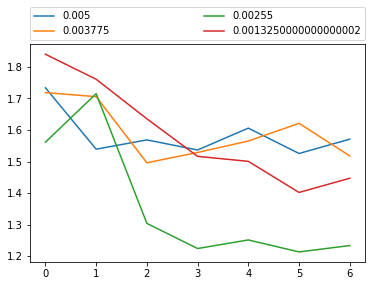

{'val_loss': [9.681787357330322],
 'val_rpn_class_loss': [2.0347118377685547],
 'val_rpn_bbox_loss': [4.822039604187012],
 'val_mrcnn_class_loss': [0.6433077299594879],
 'val_mrcnn_bbox_loss': [1.4572844099998474],
 'val_mrcnn_mask_loss': [0.7244408845901489],
 'loss': [6.472034297227859],
 'rpn_class_loss': [0.8843967587873339],
 'rpn_bbox_loss': [2.7907462072372438],
 'mrcnn_class_loss': [0.39686923583914724],
 'mrcnn_bbox_loss': [1.5778649539649487],
 'mrcnn_mask_loss': [0.8221539486646652]}

In [17]:
#loss visualization
import matplotlib.pyplot as plt

for h in histories:
    plt.plot(h['hist2'].history['loss'], label=h['lr'])
    
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    
plt.show()
hist2.history
hist1.history